In [1]:
import sys
sys.path.append('../..')

import h5py
import os
import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.simulation import run_test
from olfactory_navigation.test_setups import run_all_starts_test
from position_aware.model_6 import generate_model

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(1)

### Variables

In [3]:
# Actual data
tank_size = np.array([111,142]) # actual size: 114cm x 89cm but it is scaled by a walking speed of 0.8 cm/s
space_shape = tank_size
source_radius = 2

# State shapes
cells = np.array([9,9])
source_cell_resolution = np.array([5,5])

# Artificial data
data_mean = [50,50]
data_covariance = 50

# Data path
# folder = '/storage/arnaud/2024_06_06_sea_robins_data_for_arnaud/'
folder = '/storage/arnaud/tank_odor_field_2024_06_13/'

## Agent

In [4]:
def generate_fake_data(
        space_shape: np.ndarray,
        data_mean: list,
        data_covariance,
        samples: int
        ) -> np.ndarray:
    y,x = np.meshgrid(np.arange(space_shape[0]), np.arange(space_shape[1]))
    pos = np.dstack((y, x))
    rv = multivariate_normal(data_mean, data_covariance)
    probability_map = rv.pdf(pos).T

    # Normalize to have 1 at the center
    probability_map /= np.max(probability_map)

    multiple_samples = (np.random.random((samples, *space_shape)) < probability_map).astype(float)

    return multiple_samples

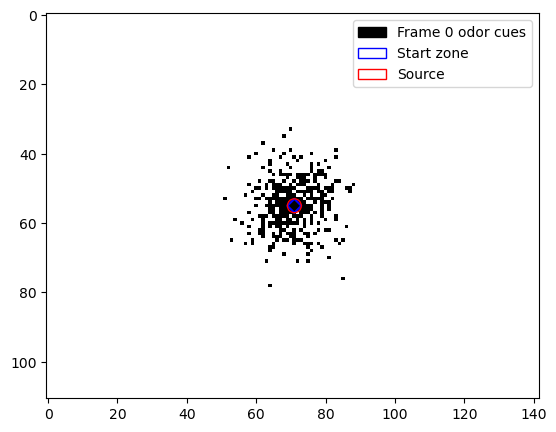

In [5]:
space_center = (space_shape/2).astype(int)

artificial_data = generate_fake_data(space_shape=space_shape,
                                     data_mean=space_center,
                                     data_covariance=data_covariance,
                                     samples=1000)

artificial_env  = Environment(data_file=artificial_data,
                              data_source_position=space_center,
                              source_radius=source_radius,
                              shape=space_shape,
                              boundary_condition='stop',
                              start_zone='data_zone',
                              odor_present_threshold=3e-1)

artificial_env.plot()

In [6]:
model = generate_model(
    space_shape=space_shape,
    cells=cells,
    source_radius=source_radius,
    source_cell_resolution=source_cell_resolution,
    data_mean=space_center,
    data_covariance=data_covariance
)

In [7]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [8]:
_ = ag.train(expansions=300, use_gpu=True)

[09/30/2024, 13:03:36] MDP_policy, not provided. Solving MDP with Value Iteration...
[09/30/2024, 13:03:36] Sending Model to GPU...
[09/30/2024, 13:03:37]     > Done in 1.321s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 8587-state, 4-action
  - Converged in 918 iterations and 1.2704 seconds
  - Took on average 0.0014s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Memory full: Out of memory allocating 38,429,641,728 bytes (allocated so far: 46,188,246,528 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 8587 state, 4 action, 163 observations
  - Converged or stopped after 140 expansion steps and 139 backup steps.
  - Resulting value function has 858 alpha vectors.
  - Converged in 167.1076s

  - Expand function took on average 0.0138s and yielded on average 584.26 beliefs per iteration. (0.0002s/it/belief)
  - Backup function took on average 1.1883s and yielded on average 6.14 alpha vectors per iteration. (0.0026s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


### Agent training validation

In [9]:
hist = run_all_starts_test(ag,
                           horizon=1000,
                           use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 56.125s:
Simulations reached goal: 15741/15749 (8 failures (reached horizon: 8)) (99.95% success)
 - Average step count:                 303.686 +- 154.01 (Successful only: 303.332 +- 153.25)
 - Extra steps:                        242.387 +- 154.72 (Successful only: 242.021 +- 153.91)
 - Average discounted rewards (ADR):   0.112 +- 0.17 (Successful only: 0.112 +- 0.17)
 - Tmin/T:                             0.254 +- 0.16 (Successful only: 0.254 +- 0.16)


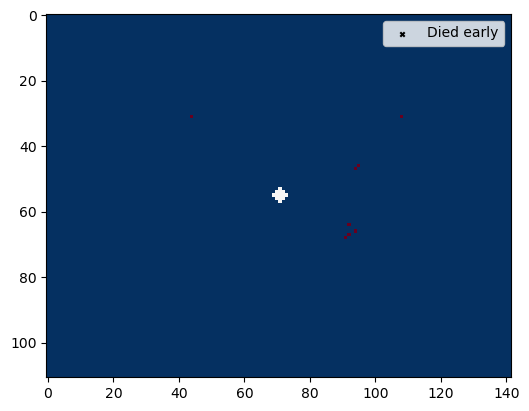

In [10]:
_, ax = plt.subplots(1,1, figsize=(6,6))
hist.plot_successes(ax)

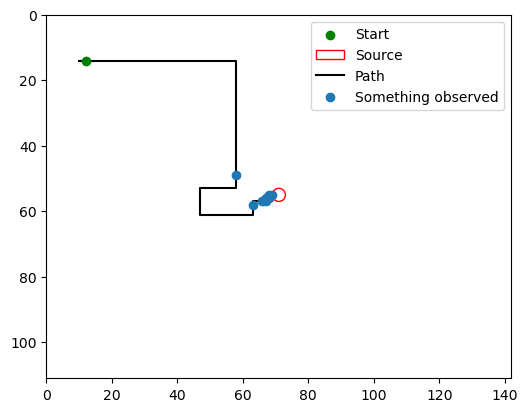

In [11]:
_, ax = plt.subplots(1,1, figsize=(6,6))
hist.plot(2000, ax=ax)

## Data loading

In [12]:
# Gathering data files
data_files = sorted(os.listdir(folder))
data_files = [file for file in data_files if file.count('_') == 1]

environments = []
for file in data_files:
    path = folder + file

    # Loading data
    loaded_data = h5py.File(path, 'r')
    data = np.array([loaded_data['odor_base'][f'{i}'] for i in range(len(loaded_data['odor_base']))])

    # Gathering source position
    data_source_position = np.argwhere(data[0] >= 1.0).mean(axis=0).astype(int)

    # Building environment
    env = Environment(data_file=data,
                    data_source_position=data_source_position,
                    source_radius=source_radius,
                    layers=False,
                    shape=space_shape,
                    boundary_condition='stop',
                    start_zone='data_zone',
                    odor_present_threshold=3e-10)

    # Saving variables in arrays
    environments.append(env)

In [13]:
all_source_positions = np.array([env.source_position for env in environments])

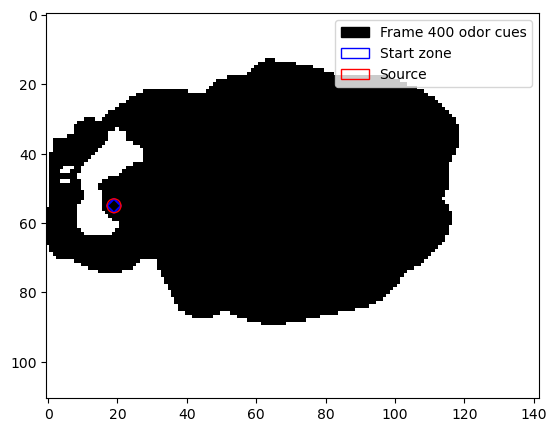

In [14]:
environments[0].plot(400)

## Setting up tests

In [15]:
all_points = np.array(list(np.ndindex(tuple(space_shape))))
starting_points = all_points[all_points[:,1] >= 110]

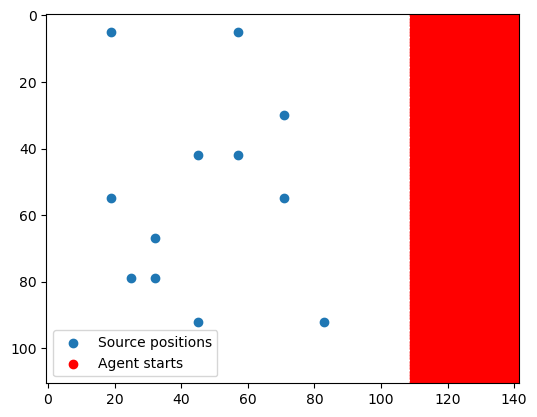

In [16]:
plt.imshow(np.zeros(space_shape), cmap='Greys')
plt.scatter(all_source_positions[:,1], all_source_positions[:,0], label='Source positions')
plt.scatter(starting_points[:,1], starting_points[:,0], color='red', label='Agent starts')
plt.legend()
plt.show()

## Running tests

In [17]:
all_hists = []
folder = './threshold_tests-9_9-5_5'

# Testing different thresholds
threshold_scales = np.arange(8) + 1
for thresh_scale in threshold_scales:
    thresh = 1 / (10 ** thresh_scale)
    ag.threshold = thresh

    thresh_hists = []

    # And different environments
    for env_i, env in enumerate(environments):

        print('--------------------------------------------')
        print(f'Threshold: 1e-{thresh_scale}; Environment: {env_i}')
        print()

        # Run test
        hist = run_test(
            agent = ag,
            start_points = starting_points,
            environment = env,
            horizon = 1199,
            use_gpu = True,
            print_progress=False
        )

        # Saving history
        hist.save(file=f't_e{thresh_scale}-env_{env_i}', folder=folder)

        thresh_hists.append(hist)

    all_hists.append(thresh_hists)

--------------------------------------------
Threshold: 1e-1; Environment: 0

Using the provided environment, not the agent environment.
Simulations done in 18.701s:
Simulations reached goal: 3174/3552 (378 failures (reached horizon: 378)) (89.36% success)
 - Average step count:                 323.963 +- 323.38 (Successful only: 219.753 +- 122.43)
 - Extra steps:                        191.716 +- 314.72 (Successful only: 90.118 +- 117.65)
 - Average discounted rewards (ADR):   0.122 +- 0.06 (Successful only: 0.137 +- 0.05)
 - Tmin/T:                             0.586 +- 0.20 (Successful only: 0.641 +- 0.13)
Simulations saved to: ./threshold_tests-9_9-5_5/t_e1-env_0.csv
Simulation's analysis saved to: ./threshold_tests-9_9-5_5/t_e1-env_0-analysis.csv
--------------------------------------------
Threshold: 1e-1; Environment: 1

Using the provided environment, not the agent environment.
Simulations done in 52.547s:
Simulations reached goal: 4/3552 (3548 failures (reached horizon: 3548)) 

## Visualize test results

In [18]:
import pandas as pd

In [19]:
rows = []

for t_i, thresh_scale in enumerate(threshold_scales):
    for env_i, env in enumerate(environments):

        hist = all_hists[t_i][env_i]
        df = hist.analysis_df

        rows.append({
            'threshold': thresh_scale,
            'environment': env_i,
            'convergence': df['converged']['mean'],
            'convergence_std': df['converged']['standard_deviation'],
            't_min_over_t': df['t_min_over_t']['success_mean'],
            't_min_over_t_std': df['t_min_over_t']['success_standard_deviation']
        })

In [20]:
res_df = pd.DataFrame(rows)

In [21]:
res_df

,threshold,environment,convergence,convergence_std,t_min_over_t,t_min_over_t_std
0,1,0,0.893581,0.308373,0.640876,0.129978
1,1,1,0.001126,0.033539,0.146818,0.016866
2,1,2,0.026182,0.159678,0.118632,0.012202
3,1,3,0.369932,0.482786,0.382361,0.275471
4,1,4,0.301239,0.458796,0.171805,0.069478
...,...,...,...,...,...,...
91,8,7,0.460023,0.498399,0.278820,0.057997
92,8,8,0.000000,0.000000,NaN,NaN
93,8,9,0.088119,0.283468,0.174910,0.117366
94,8,10,0.983671,0.126737,0.307041,0.087307


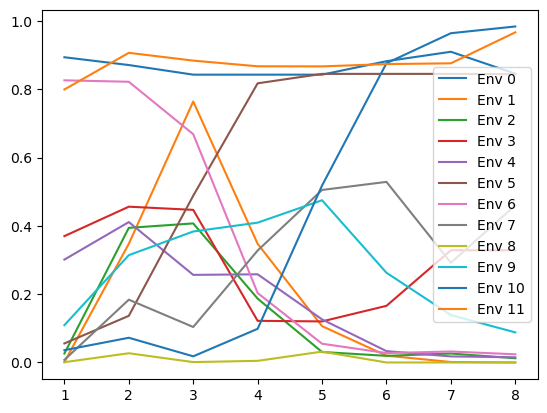

In [22]:
for env_i, env in enumerate(environments):
    plt.plot(threshold_scales, res_df[res_df['environment'] == env_i]['convergence'], label = f'Env {env_i}')

plt.legend()

<Axes: xlabel='threshold'>

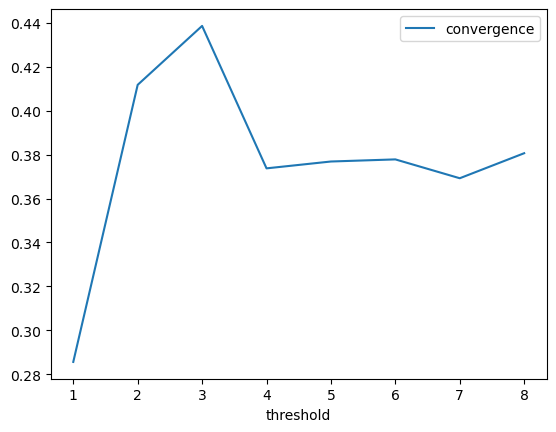

In [23]:
res_df.groupby('threshold').mean().plot(y='convergence')

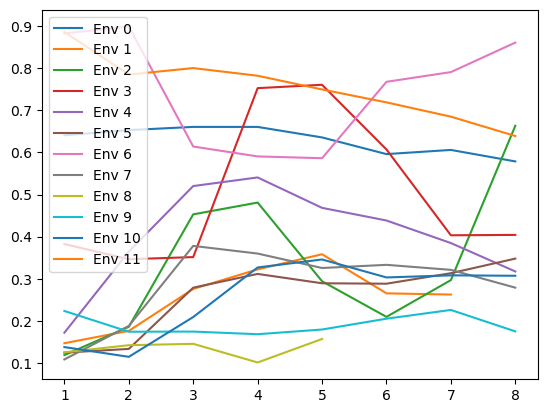

In [24]:
for env_i, env in enumerate(environments):
    plt.plot(threshold_scales, res_df[res_df['environment'] == env_i]['t_min_over_t'], label = f'Env {env_i}')

plt.legend()

<Axes: xlabel='threshold'>

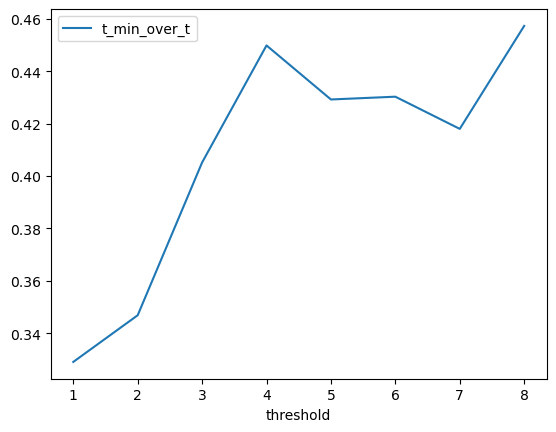

In [25]:
res_df.groupby('threshold').mean().plot(y='t_min_over_t')